# adaptive filter ?

## to be honest, i am not sure how it should be called

The goal is to reduce bus load while using high resolution high rate cc

### overall sequence:
1. first stage filter to slightly reduce noise
2. adaptive filter, which fc is the function of absolute (squared) error
3. hysteresis circuit (lowest 3 bits)

### result: 11 + 3 bits (14 midi bits)

DIAL_GAIN: 0x80000


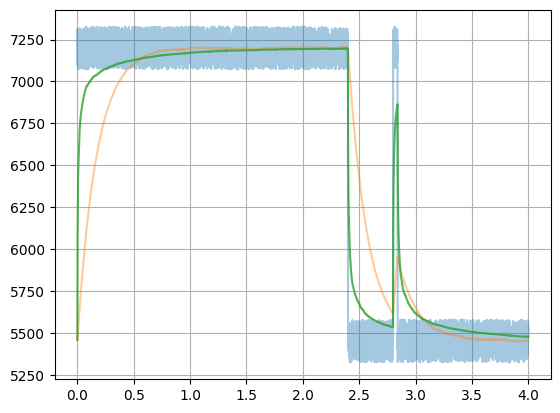

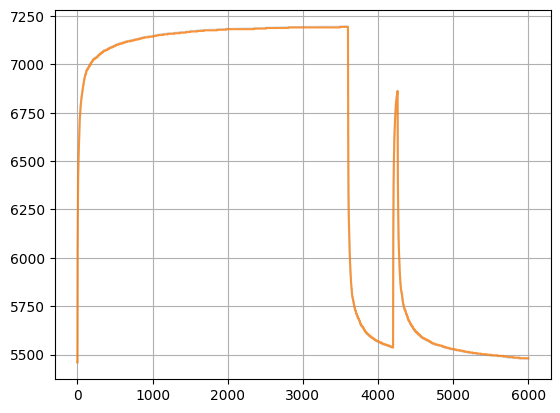

In [76]:
import numpy as np
import matplotlib.pyplot as plt

BITS_ADC = 12 # 4096 values
# BITS_CLEAN = 8 # average case
# BITS_CLEAN = 7 # midi case
BITS_CLEAN = 6 # worst case
BITS_NOISE = BITS_ADC - BITS_CLEAN

SAMPLE_RATE_HZ = 48000 / 4 / 8

TEST_TIME_S = 4

DIAL_INIT = 0.3332 # normalized 0..1
DIAL_GOAL = 0.4395
DIAL_GOAL_2 = 0.3330
# init is the filter init value
# goal is the dial actual value

LEN = int(SAMPLE_RATE_HZ * TEST_TIME_S)

dial = np.empty(LEN ,np.int32)
dial[:] = int(DIAL_GOAL * (2**BITS_ADC))
dial[int(LEN * 0.6):] = int(DIAL_GOAL_2 * (2**BITS_ADC)) # step 2
dial[int(LEN * 0.7):] = int(DIAL_GOAL * (2**BITS_ADC)) # step 2
dial[int(LEN * 0.71):] = int(DIAL_GOAL_2 * (2**BITS_ADC)) # step 2
dial = dial + (np.random.rand(LEN) * (2**BITS_NOISE) - (2**BITS_NOISE)/2)

BITS_FILTER = 31
flt = np.empty(LEN ,np.int32)
flt[:] = int(DIAL_INIT * (2**BITS_FILTER))

DIAL_GAIN = 2**(BITS_FILTER - BITS_ADC)
print(f"DIAL_GAIN: {hex(DIAL_GAIN)}")

PRECF = 256
preflt = np.array(dial)
preflt[0] = int(DIAL_INIT * (2**BITS_ADC) * PRECF)


for i in range(1, len(flt)):
    preflt[i] = preflt[i-1] + (dial[i] * PRECF - preflt[i-1]) / PRECF
    # delta = preflt[i]/PRECF - flt[i-1] / DIAL_GAIN
    delta = dial[i] - flt[i-1] / DIAL_GAIN
    absd = delta
    if absd < 0: absd = -absd
    # absd += 16
    absd = absd * absd / 2
    # and we need somehow convert ~18 bit to 18 values
    if absd > DIAL_GAIN: absd = DIAL_GAIN
    filter_coef = absd
    # filter_coef = DIAL_GAIN
    # basic filter
    flt[i] = flt[i-1] + delta * filter_coef


# START = int(LEN * 0.5)
START = 0

flt = (flt / (2**(BITS_FILTER - 14))).astype(int)
# flt = flt & 0xFFFFF0
preflt = (preflt / (PRECF/4)).astype(int)
# plt.plot(flt, alpha=0.8)
t = np.linspace(0,TEST_TIME_S,len(flt[START:]))
plt.plot(t, dial[START:]*4, alpha=0.4)
plt.plot(t, preflt[START:], alpha=0.4)
plt.plot(t, flt[START:], alpha=0.8)
plt.grid()
plt.show()

HYST = 4
dbg = np.array(flt)
for i in range(1, len(flt)):
    if abs(dbg[i-1] - flt[i-1]) > HYST:
        dbg[i] = flt[i-1] + np.sign(dbg[i-1] - flt[i-1]) * int(HYST / 2)
    else:
        dbg[i] = dbg[i-1]

# START = int(LEN * 0.2)
plt.plot(flt[START:], alpha=0.2)
plt.plot(dbg[START:], alpha=0.8)
plt.grid()
plt.show()


